In [82]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert
import matplotlib.pyplot as plt

In [83]:
plt.rcParams["font.family"] = "Arial"
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
plt.rcParams['axes.linewidth'] = 2 # set the value globally
plt.rcParams['figure.dpi'] = 150

In [84]:
def get_hilbert_trans(signal: np.ndarray, fs: float, unwrap: bool=False) -> np.ndarray:
    analytic_signal = hilbert(signal)
    HT_imag = np.imag(analytic_signal)
    amplitude_envelope = np.abs(analytic_signal)
    if unwrap:
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    else:
        instantaneous_phase = np.angle(analytic_signal)
    instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * fs)
    return instantaneous_phase

def remove_nan(data: np.ndarray)-> np.ndarray:
    data_out = data[~np.isnan(data)]
    return data_out

def get_damping_from_phase(phase_shift: np.ndarray) -> np.ndarray:
    r'''
    Damping ratio -[%]
    '''
    return np.sin(np.abs(phase_shift/2)) *100

In [85]:
#filepath = r"D:\Research\Paper\IrregularDamping\DeepSoil\Results_profile_0_motion_Northridge.xlsx"
filepath = r"D:\Research\Paper\IrregularDamping\DeepSoil\Results_profile_0_motion_Northridge_low.xlsx"
df = pd.read_excel(filepath, sheet_name='Layer 19')
df

,Time (s),Acceleration (g),Strain (%),Shear Stress Ratio (Shear/Eff. Vert.),Shear Stress(psf),Arias intensity (ft/s),Housner Intensity (ft/s),Unnamed: 7,Period (sec),PSA (g),Unnamed: 10,Frequency (Hz),Fourier Amplitude (g-sec),Fourier Amplitude Ratio
0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,NaN,0.010000,0.027619,NaN,0.006104,0.000011,75.809492
1,0.02,-4.532664e-07,-1.018414e-08,-7.089715e-08,-0.000411,2.077031e-13,2.032709e-07,NaN,0.010641,0.027596,NaN,0.012207,0.000011,150.521325
2,0.04,1.286128e-08,-5.477998e-08,-3.813517e-07,-0.002213,2.078703e-13,4.226468e-07,NaN,0.011323,0.027671,NaN,0.018311,0.000011,51.636154
3,0.06,-6.446621e-07,-7.891899e-08,-5.493954e-07,-0.003188,6.280162e-13,6.504238e-07,NaN,0.012050,0.027695,NaN,0.024414,0.000011,17.955701
4,0.08,-2.352156e-07,-9.642649e-08,-6.712736e-07,-0.003895,6.839492e-13,9.048936e-07,NaN,0.012822,0.027684,NaN,0.030518,0.000010,10.182890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.975586,0.000024,1.778601
4092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.981689,0.000021,1.271210
4093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.987793,0.000021,1.297819
4094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.993896,0.000022,1.700217


### Get signals for `Hilbert Transform`

In [86]:
stress_signal = remove_nan(df['Shear Stress(psf)'].to_numpy())
strain_signal = remove_nan(df['Strain (%)'].to_numpy())
time = remove_nan(df['Time (s)'].to_numpy())
timeStep = time[2] - time[1]
fs = 1/timeStep
signal_length = len(time)

In [87]:
stress_phase = get_hilbert_trans(stress_signal, fs)
strain_phase = get_hilbert_trans(strain_signal, fs)
phaseShift_raw = stress_phase - strain_phase
damping_raw = get_damping_from_phase(phaseShift_raw)

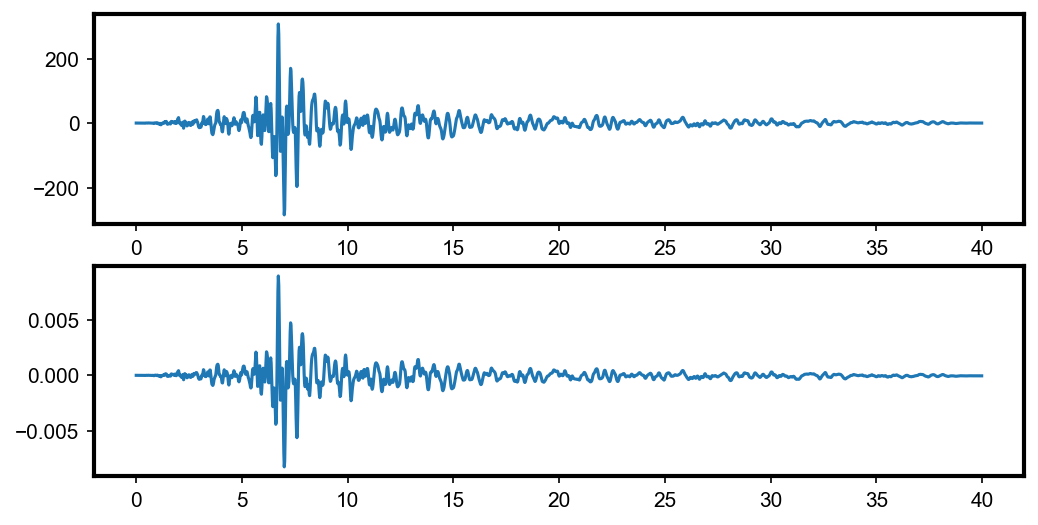

In [88]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))
axs[0].plot(time, stress_signal, label='Raw')
axs[1].plot(time, strain_signal, label='Raw')
plt.show()
plt.close()

In [89]:
def smooth(data: np.ndarray, box_pts: float) -> np.ndarray:
    box = np.ones(box_pts)/box_pts
    data_smooth = np.convolve(data, box, mode='same')
    return data_smooth

In [94]:
phaseShift_filtered = smooth(data=phaseShift_raw, box_pts=signal_length)
damping_filtered = get_damping_from_phase(phaseShift_filtered)

(-1.0, 1.0)

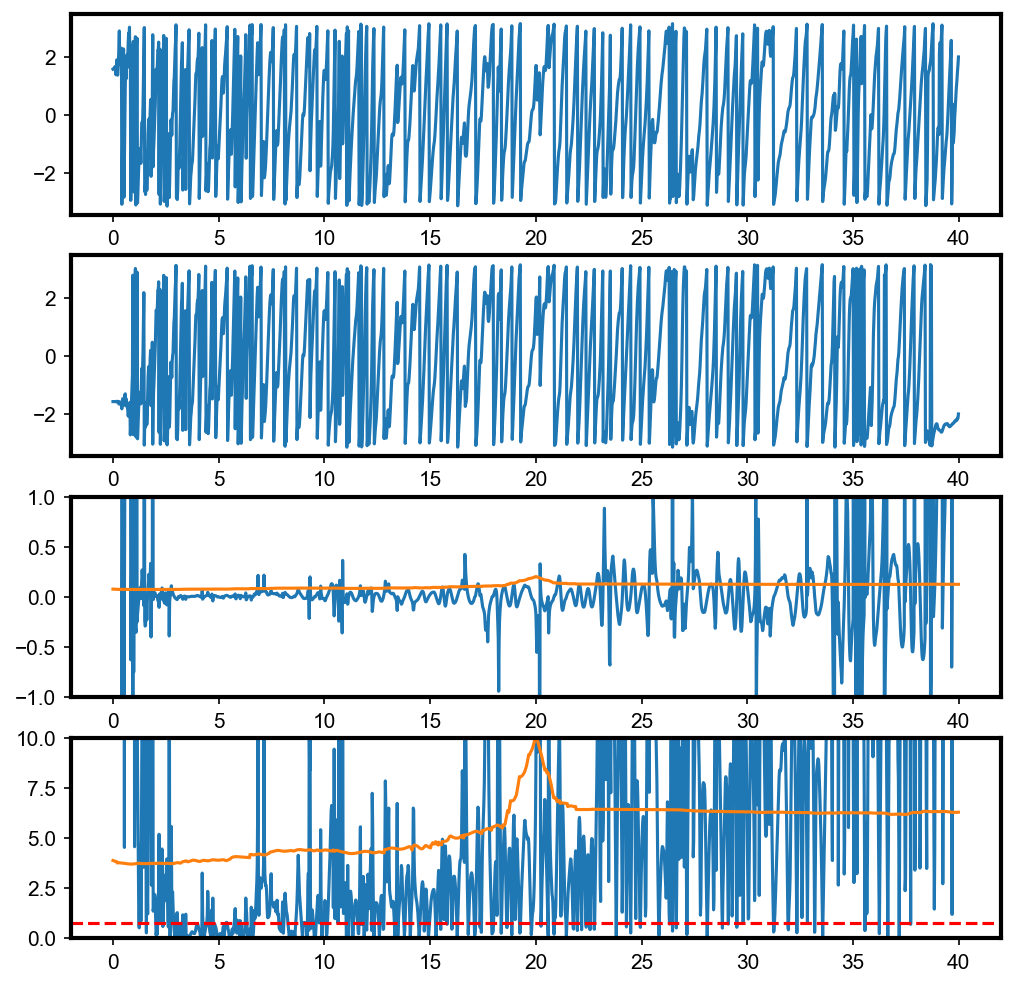

In [95]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 8))
axs[0].plot(time, stress_phase, label='Raw')
axs[1].plot(time, strain_phase, label='Raw')
axs[2].plot(time, phaseShift_raw, label='Raw')
axs[2].plot(time, phaseShift_filtered, label='Filtered')
axs[3].plot(time, damping_raw, label='Raw')
axs[3].plot(time, damping_filtered, label='Filtered')
axs[3].axhline(y=0.77, color='red', linestyle='--')
axs[3].set_ylim(0, 10)
axs[2].set_ylim(-1, 1)